In [ ]:
# use mixmatch on hematoxylin channel and apply to probability slide
# add masking to mixmatch and hematoxylin deconv

In [ ]:
! pip install  git+https://github.com/airlab-unibas/airlab

In [ ]:
! cd PathFlow-MixMatch/ && pip install . --no-deps

In [ ]:
# ! cd PathFlowAI && pip install . --no-deps

In [ ]:
# plt.imshow(img)

In [ ]:
# from skimage.exposure import rescale_intensity
# from skimage.color import rgb2hed

# hed=rgb2hed(img)
# hed[...,0]=rescale_intensity(hed[:, :, 0], out_range=(0, 1))


In [ ]:
# plt.imshow(hed[...,0])

In [ ]:
# plt.imshow(hed[...,0]==0)

In [ ]:
# mask=generate_tissue_mask(img)

In [ ]:
# plt.imshow(mask)

In [ ]:
# res=affine_register(im2_tmp,im1_tmp,
#                iterations=1000,
#                     lr=1e-2,
#                     transform_type='rigid',
#                     gpu_device=0,
#                     opt_cm=True,
#                     sigma=[[11,11],[11,11],[3,3]],
#                     order=2,
#                     pyramid=[[4,4],[2,2]],
#                     loss_fn="ncc",#'ncc',
#                     use_mask=True,
#                     interpolation='bicubic',
#                     half=False,
#                     regularisation_weight=[1,5,50],
#                     moving_image=None,
#                     register_joint_domain=False,
#                     use_hematoxylin=False,
#                    mask1=mask2,
#                    mask2=mask1)

# upsample displacement field, or just utilize transformation parameters


In [ ]:
# transform_params={k:v.detach().cpu().numpy() for k,v in dict(res['transformation_param']).items()}
# transform_params['_phi_z'].resize(1)

In [ ]:
# transform_params

In [ ]:
# transform_params

In [ ]:
# transform_params2=transform_params.copy()
# transform_params_new={}
# transform_params_new['t']=torch.tensor(np.array([transform_params2[f'_t_{k}'] for k in ['x','y']]))
# # transform_params_new['scale']=torch.tensor(np.ones(2).astype(float))#np.array([transform_params2[f'_scale_{k}'] for k in ['x','y']])
# transform_params_new['rotation_center']=torch.tensor(np.array([transform_params2[f'_center_mass_{k}'] for k in ['x','y']]))
# transform_params_new['phi']=torch.tensor(transform_params['_phi_z'])

In [ ]:
# transform_params_new

In [ ]:


# dtype = th.float32
# device = th.device("cpu")#th.device("cuda:0")
# moving_image=al.image_from_numpy(im2[...,0], [1, 1], [0, 0], dtype=dtype, device=device)#al.utils.image.create_tensor_image_from_itk_image(sitk.GetImageFromArray(im2), dtype=th.float32, device='cpu')

# transformation=RigidTransformation(moving_image)


In [ ]:
# transformation.set_parameters(**transform_params_new)

In [ ]:
# transformation_matrix = transformation._compute_transformation_matrix()
# displacement = transformation.get_displacement()#_concatenate_flows(transformation._compute_dense_flow(transformation_matrix))



In [ ]:
# displacement.shape

In [ ]:
# im2_transformed=displace_image(im2, displacement, -1, dtype=th.float32)

In [ ]:
# plt.imshow(im2_transformed)

In [ ]:
# plt.imshow(im1-im2_transformed)

In [ ]:
# plt.imshow(im2)

In [ ]:
# plt.imshow(im1)

In [ ]:
# plt.imshow(generate_tissue_mask(im1_tmp,compression=compression,threshold=240))

In [ ]:
# plt.imshow(generate_tissue_mask(im2_tmp,compression=compression,threshold=240))

In [ ]:
# plt.imshow(generate_tissue_mask(im2_tmp,compression=compression,threshold=40))

In [1]:
import sys, os
sys.path.insert(0,"/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/")
import torch

import numpy as np, cv2

from pathflowai.utils import generate_tissue_mask

import matplotlib; matplotlib.rcParams['figure.dpi']=300
import matplotlib.pyplot as plt

from pathflow_mixmatch.cli import match_image_size, affine_register, displace_image

from pathflowai.utils import generate_tissue_mask
import torch as th

import airlab as al
import SimpleITK as sitk
from airlab.transformation.pairwise import SimilarityTransformation, RigidTransformation

nonechucks may not work properly with this version of PyTorch (1.6.0). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [2]:

import glob
def rotate_image(mat, angle, center=None):
    """
    https://stackoverflow.com/questions/43892506/opencv-python-rotate-image-without-cropping-sides/47248339
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    
    
    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center if center is None else center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = np.abs(rotation_mat[0,0])
    abs_sin = np.abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h), borderValue=(255,255,255))
    return rotated_mat

basename="140_A1c"
files=sorted(glob.glob(f"bcc/interactive_test/{basename}.img.*.png"), key=lambda x: int(x.split('.')[-2]))
center_img=int(len(files)/2)
compression=4
threshold=230

In [3]:
import kornia.augmentation as K, kornia.geometry.transform as G
import kornia
from kornia.augmentation import AugmentationBase

class Rotate(AugmentationBase):
    def __init__(self, return_transform: bool = False, angle: float = 90) -> None:
        super(RandRotate, self).__init__(return_transform)
        self.angle=angle

    def generate_parameters(self, input_shape: torch.Size):
        angles_rad = (torch.rand(input_shape[0])-0.5) * self.angle * np.pi/180.
        angles_deg = kornia.rad2deg(angles_rad)
        return dict(angles=angles_deg)

    def compute_transformation(self, input, params):
        B, _, H, W = input.shape
        angles= params['angles'].type_as(input)
        center = torch.tensor([[W / 2, H / 2]] * B).type_as(input)
        transform = G.get_rotation_matrix2d(
            center, angles, torch.ones_like(angles))
        self.cos=torch.abs(transform[0, 0, 0])
        self.sin=torch.abs(transform[0, 0, 1])
        self.center=center
        return transform

    def apply_transform(self, input, params):
        _, _, H, W = input.shape
        transform = self.compute_transformation(input, params)
        nW = int((H * self.sin) + (W * self.cos))
        nH = int((H * self.cos) + (W * self.sin))
        transform[0, 0, 2] += (nW / 2) - self.center[0,0]
        transform[0, 1, 2] += (nH / 2) - self.center[0,1]
        output = 1.-G.warp_affine(1.-input, transform, (nH, nW))
        return (output, transform)[0]

ImportError: cannot import name 'AugmentationBase' from 'kornia.augmentation' (/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/kornia/augmentation/__init__.py)

In [ ]:
files

In [ ]:
from pathflowai.utils import label_objects
import pandas as pd
from skimage import measure

def load_vert(f):
    img=cv2.cvtColor(cv2.imread(f),cv2.COLOR_BGR2RGB)
    mask=generate_tissue_mask(img,compression=compression,threshold=threshold)
    im=cv2.resize(img,None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_CUBIC)
    _,labels=label_objects(im,
                    otsu=False,
                    min_object_size=100000,
                    threshold=230,
                    connectivity=8,
                    kernel=61,
                    keep_holes=False,
                    max_hole_size=0)
    props=pd.DataFrame(measure.regionprops_table(labels, cv2.cvtColor(im, cv2.COLOR_BGR2GRAY),properties=['area','orientation'])).sort_values(['area'],ascending=False).reset_index(drop=True)
    angle=-props.loc[0,'orientation']*180./(np.pi)
    vert_img=rotate_image(img, angle)
    return vert_img,angle

imgs=[]
for f in files:
    print(f)
    imgs.append(load_vert(f))
# img=im1[props.iloc[i,0]:props.iloc[i,2],props.iloc[i,1]:props.iloc[i,3]].copy()

# props = pd.DataFrame(measure.regionprops_table(labels, cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY),properties=properties))
# props2 = pd.DataFrame(measure.regionprops_table(labels2, cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY),properties=properties))



# add some width

In [ ]:
props

In [ ]:



#'bbox',


In [ ]:
# plt.imshow(target_img_vert)

In [ ]:

target_img_vert

# I should really rotate to vertical orientation
# how to get matching between layers??
img=cv2.cvtColor(cv2.imread(),cv2.COLOR_BGR2RGB)
im1=img
im2=cv2.cvtColor(cv2.imread("bcc/interactive_test/140_A1c.img.1.png"),cv2.COLOR_BGR2RGB)

im1,im2,dw,dh=match_image_size(im1,im2,black_background=False)

downsample=4.
im1_tmp,im2_tmp=cv2.resize(im1,None,fx=1./downsample,fy=1./downsample),cv2.resize(im2,None,fx=1./downsample,fy=1./downsample) 

threshold=230
compression=2
# mask1,mask2=th.tensor(generate_tissue_mask(im1_tmp,compression=compression,threshold=threshold)),th.tensor(generate_tissue_mask(im2_tmp,compression=compression,threshold=threshold))


In [ ]:
# ! ls bcc/interactive_test/
# START HERE

In [ ]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import skimage.io
import numpy as np
import cv2

downsample=8
compression=2
im1,im2=cv2.resize(skimage.io.imread("bcc/interactive_test/163_A1a.img.0.png"),None,fx=1./downsample,fy=1./downsample),cv2.resize(skimage.io.imread("bcc/interactive_test/163_A1a.img.1.png"),None,fx=1./downsample,fy=1./downsample) 



In [ ]:
from pathflowai.utils import generate_tissue_mask
threshold=230
mask1,mask2=generate_tissue_mask(im1,compression=compression,threshold=threshold),generate_tissue_mask(im2,compression=compression,threshold=threshold)


In [ ]:
# p1.shape
from probreg import filterreg
from probreg import callbacks
import matplotlib.pyplot as plt
# import utils
# shape matching within patiient then sequential
import numpy as np
# add features
# X_new2=[X_new[i] for i in np.where(c==0)[0]]
# for i in range(1,len(X_new2)):
sub_sample=180,180
p1=np.vstack(np.where(mask1)).T[::sub_sample[0]]#.numpy()
p2=np.vstack(np.where(mask2)).T[::sub_sample[1]]# .numpy()
source, target = p1,p2#X_new2[i],X_new2[0]#-X[0].max(0)-X[1].max(0)
cbs = [callbacks.Plot2DCallback(source, target,save=True)]
tf_param, _, _ = filterreg.registration_filterreg(source, target, # feature_fn
                                              objective_type="pt2pt",
                                              callbacks=cbs,
                                              maxiter=50,
                                              tf_init_params={"rot": np.identity(2), "t": np.zeros(2)})

# plt.scatter(*p1.T.tolist(),s=1)

In [ ]:
! convert   -delay 10   -loop 0   *.png   animate_test.gif 

![](animate_test2.gif)

In [ ]:
# ! rm image_*.png

In [6]:
def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

In [7]:
def translate_rotate_image(mat, angle, center=None):
    """
    https://stackoverflow.com/questions/43892506/opencv-python-rotate-image-without-cropping-sides/47248339
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    #translate
    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2)
    translated_mat = cv2.warpAffine(mat, np.hstack((np.eye(2),(-np.array(center)[::-1]).reshape(-1,1))), (width, height), borderValue=(255,255,255))
    
    height, width = translated_mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = np.abs(rotation_mat[0,0])
    abs_sin = np.abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(translated_mat, rotation_mat, (bound_w, bound_h), borderValue=(255,255,255))
    return rotated_mat

In [ ]:
from pathflow_mixmatch.cli import rotate_image,match_image_size

In [ ]:
# im1.shape
params

In [ ]:
params=dict(angle=np.arccos(tf_param.rot[0,0])*180/np.pi,
           center=tuple(((p1.mean(0)[::-1]-tf_param.t[::-1])).tolist()))#4*
im_new=rotate_image(im1,**params)#rotate_image
im_new[im_new.sum(2)==0,:]=255
im_new[cv2.cvtColor(im_new,cv2.COLOR_RGB2GRAY)>220,:]=255

In [ ]:
im_new,im2_new,_,_=match_image_size(im_new,im2)
# im_new=translate_rotate_image(im1,**params)
# im_new[im_new.sum(2)==0,:]=255
# im_new[cv2.cvtColor(im_new,cv2.COLOR_RGB2GRAY)>220,:]=255

In [ ]:
plt.imshow(im1)

In [ ]:
plt.imshow(im2)

In [ ]:
plt.imshow(im_new)

In [ ]:
plt.imshow(im2_new)

In [ ]:
params

In [ ]:
# im_new=rotate(im1,**params)
# im_new[im_new.sum(2)==0,:]=255
# im_new[cv2.cvtColor(im_new,cv2.COLOR_RGB2GRAY)>220,:]=255
# plt.imshow(im_new)

In [ ]:
from skimage.util import compare_images


comp = compare_images(*match_image_size(im1,im2)[:2], method='blend')#np.stack([compare_images(im2[...,i], im_new[...,i], method='blend') for i in range(3)],axis=-1)
plt.imshow(comp)

In [ ]:
from skimage.util import compare_images


comp = compare_images(im2_new, im_new, method='blend')#np.stack([compare_images(im2[...,i], im_new[...,i], method='blend') for i in range(3)],axis=-1)
plt.imshow(comp)

In [ ]:
# approximate, need to improve this workflow

In [ ]:
# im2.shape

In [ ]:
# im_new.shape

In [ ]:
# plt.imshow(im2)

In [ ]:
# image


In [ ]:
# tf_param.t*img2.shape#p2.max(0)/2

In [ ]:
# plt.imshow(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)<255)

In [ ]:
# import copy
# def warp_RGB(img, displacement):
    
#     moving_image=al.image_from_numpy(im2, [1, 1], [0, 0], dtype=dtype, device=device)#al.utils.image.create_tensor_image_from_itk_image(sitk.GetImageFromArray(im2), dtype=th.float32, device='cpu')

#     RGB=[al.transformation.utils.warp_image(al.image_from_numpy(img[:,:,i], [1, 1], [0, 0], dtype=dtype, device=device), displacement) for i in range(3)]
    
#     img2=copy.deepcopy(img)
#     for i,ch in enumerate(RGB):
#         img2[:,:,i] = np.asarray(ch.numpy())

#     return img


In [ ]:
# im2_new=warp_RGB(im2,displacement)

In [ ]:
########### NEW

In [ ]:
! ls -lah bcc/graph_datasets/

In [8]:
import pickle
deep_features_graphs=pickle.load(open('bcc/graph_datasets/imagenet_graph_data_256_new.pkl','rb'))

In [9]:
deep_features_graphs['graph_dataset'][0]

Data(edge_index=[2, 14120], id="88_A1a", pos=[1630, 2], test_mask=[1630], train_mask=[1630], val_mask=[1630], x=[1630, 1000], y=[1630])

In [10]:
# add point cloud loss and deep feature loss, maybe add multiple slides?

In [11]:
from geomloss import SamplesLoss

In [ ]:
torch.cos(torch.tensor(0.))

In [12]:
# loss(X.pos,X.pos)

In [13]:
df=deep_features_graphs['df']

In [14]:
from sklearn.neighbors import NearestNeighbors
graphs=df.groupby(['ID'])[["x","y"]].apply(lambda x: NearestNeighbors(radius=256*np.sqrt(2),n_jobs=25).fit(x.values).radius_neighbors_graph(x.values))

In [15]:
import scipy.sparse as sps
components=graphs.apply(lambda x: sps.csgraph.connected_components(x)[1])

In [16]:
import pandas as pd
from collections import Counter
df['y_true']=df['annotation'].apply(lambda x: "Incomplete" in x)#Incomplete_Area
point_clouds=[]
for name,dff in df.groupby(['ID']):
    xy=dff[["x","y",'y_true']]
    xy['components']=components.loc[name]
    for name2, xy2 in xy.groupby('components'):
        if xy2.shape[0]>300:
            point_clouds.append((name,name2,(xy2['y_true']>0).mean()>0,xy2[['x','y']].values))
            
point_clouds=pd.DataFrame(point_clouds,columns=['slide','component','incomplete','points'])

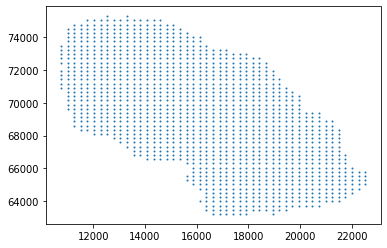

In [17]:
plt.scatter(*point_clouds['points'][5].T.tolist(),s=1)

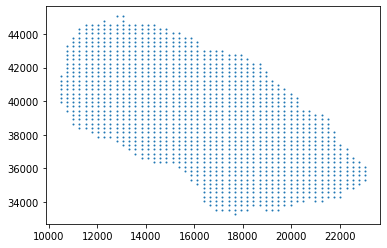

In [18]:
plt.scatter(*point_clouds['points'][4].T.tolist(),s=1)

In [19]:
# [param for param in net.parameters()]

In [90]:
from torch_cluster import nearest
from torch import nn
class RotNet(nn.Module):
    def __init__(self,orig_cloud,target_cloud):
        super(RotNet,self).__init__()
        self.theta=nn.Parameter(torch.tensor(0.,requires_grad=True))
        self.t=nn.Parameter(-(orig_cloud.mean(0)-target_cloud.mean(0)))
        self._dim=2
        
#     def compute_loss(self,pos_source,pos_target,z_source,z_target):
    def generate_rot_matrix(self):
        R = th.zeros(self._dim + 1, self._dim + 1)
        R[-1, -1] = 1

        R[0, 2] = self.t[0]
        R[1, 2] = self.t[1]
        
        R[0, 0] = th.cos(self.theta)
        R[0, 1] = -th.sin(self.theta)
        R[1, 0] = th.sin(self.theta)
        R[1, 1] = th.cos(self.theta)
        return R
        
#         return torch.tensor([[torch.cos(self.theta),-torch.sin(self.theta),self.tx],
#                             [torch.sin(self.theta),torch.cos(self.theta),self.ty],
#                             [0,0,1]])
    
    def forward(self,pos):#,pos_target,z_source=None,z_target=None):
        R=self.generate_rot_matrix()
        ones=torch.ones((len(pos),1))
#         if torch.cuda.is_available(): ones=ones.cuda()
        pos=torch.cat([pos,ones],1).transpose(1,0)
        return torch.mm(R,pos).T[:,:2]

In [92]:
# theta=nn.Parameter(torch.tensor(0.,requires_grad=True))
# tx=nn.Parameter(torch.tensor(0.,requires_grad=True))
# ty=nn.Parameter(torch.tensor(0.,requires_grad=True))
# R=torch.tensor([[torch.cos(theta),-torch.sin(theta),tx],
#                             [torch.sin(theta),torch.cos(theta),ty],
#                             [0,0,1]],requires_grad=True)
# R=torch.zeros((3,3),requires_grad=True)

# pos=torch.cat([target_pos,torch.ones((len(target_pos),1))],1).transpose(1,0)

In [93]:
# net=nn.Linear(2,5)

In [94]:
# net(target_pos)
# net=RotNet()
# net(target_pos).mean().backward()

In [95]:
# torch.mm(R,pos).T[:,:2].backward()

In [96]:
# ! pip install git+

In [109]:
[param for param in net.parameters()]

[Parameter containing:
 tensor(0.0028, requires_grad=True),
 Parameter containing:
 tensor([ -2929.7976, -31688.3633], requires_grad=True)]

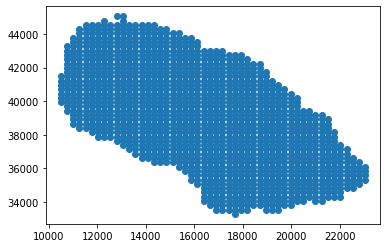

In [107]:
plt.scatter(*pts.numpy().T.tolist())

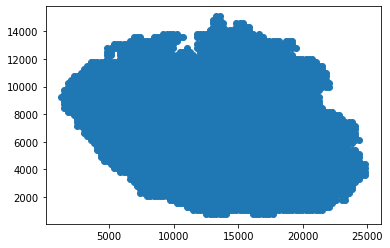

In [110]:
plt.scatter(*target_pos.numpy().T.tolist())

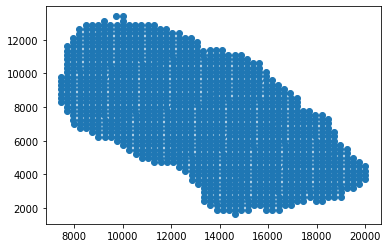

In [108]:
plt.scatter(*net(pts).detach().numpy().T.tolist())

In [100]:
pts,net(pts),target_pos

(tensor([[10496., 39936.],
         [10496., 40192.],
         [10496., 40448.],
         ...,
         [23040., 35584.],
         [23040., 35840.],
         [23040., 36096.]]),
 tensor([[10409.7871, 70087.0156],
         [10409.8711, 70343.0156],
         [10409.9561, 70599.0156],
         ...,
         [22952.3535, 65730.8828],
         [22952.4375, 65986.8828],
         [22952.5215, 66242.8828]], grad_fn=<SliceBackward>),
 tensor([[10752., 70912.],
         [10752., 71168.],
         [10752., 71424.],
         ...,
         [22528., 65280.],
         [22528., 65536.],
         [22528., 65792.]]))

In [113]:
from torch_cluster import knn

In [114]:
knn(target_pos,pts,5) # use torch scatter to compute loss over imagenet features

tensor([[   0,    0,    0,  ..., 1345, 1345, 1345],
        [1751, 1808, 1694,  ..., 2128, 2235, 2074]])

In [112]:
# combine with distributional matching loss, maybe there's better point cloud loss function

criterion=SamplesLoss(loss="sinkhorn", p=2, blur=.05, backend="tensorized")
pts=torch.tensor(point_clouds['points'][4]).float()
target_pos=torch.tensor(point_clouds['points'][6]).float()
net=RotNet(pts,target_pos)
net.train()
optimizer=torch.optim.Adam(net.parameters(),lr=1e-3)
for i in range(100):
    t_pos=net(pts)
#     print(t_pos,target_pos)
    train_loss=criterion(t_pos,target_pos)
    print(train_loss)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    

tensor(3927695., grad_fn=<SelectBackward>)
tensor(3925232.5000, grad_fn=<SelectBackward>)
tensor(3924564.5000, grad_fn=<SelectBackward>)
tensor(3925385.7500, grad_fn=<SelectBackward>)
tensor(3927006.5000, grad_fn=<SelectBackward>)
tensor(3928754., grad_fn=<SelectBackward>)
tensor(3930200., grad_fn=<SelectBackward>)
tensor(3930625., grad_fn=<SelectBackward>)
tensor(3930007.5000, grad_fn=<SelectBackward>)
tensor(3928717., grad_fn=<SelectBackward>)
tensor(3927266.5000, grad_fn=<SelectBackward>)
tensor(3926084.7500, grad_fn=<SelectBackward>)
tensor(3925233.7500, grad_fn=<SelectBackward>)
tensor(3924769.2500, grad_fn=<SelectBackward>)
tensor(3924591., grad_fn=<SelectBackward>)
tensor(3924554.5000, grad_fn=<SelectBackward>)
tensor(3924562.5000, grad_fn=<SelectBackward>)
tensor(3924566.5000, grad_fn=<SelectBackward>)
tensor(3924563., grad_fn=<SelectBackward>)
tensor(3924555., grad_fn=<SelectBackward>)
tensor(3924569.7500, grad_fn=<SelectBackward>)
tensor(3924657., grad_fn=<SelectBackward>)
te

In [ ]:
# import torch
# import torch.nn.functional as F
# from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d as BN
# from torch_geometric.datasets import ModelNet
# import torch_geometric.transforms as T
# from torch_geometric.data import DataLoader
# from torch_geometric.nn import PointConv, fps, radius, global_max_pool


# class SAModule(torch.nn.Module):
#     def __init__(self, ratio, r, nn):
#         super(SAModule, self).__init__()
#         self.ratio = ratio
#         self.r = r
#         self.conv = PointConv(nn)

#     def forward(self, x, pos, batch):
#         idx = fps(pos, batch, ratio=self.ratio)
#         row, col = radius(pos, pos[idx], self.r, batch, batch[idx],
#                           max_num_neighbors=64)
#         edge_index = torch.stack([col, row], dim=0)
#         x = self.conv(x, (pos, pos[idx]), edge_index)
#         pos, batch = pos[idx], batch[idx]
#         return x, pos, batch


# class GlobalSAModule(torch.nn.Module):
#     def __init__(self, nn):
#         super(GlobalSAModule, self).__init__()
#         self.nn = nn

#     def forward(self, x, pos, batch):
#         x = self.nn(torch.cat([x, pos], dim=1))
#         x = global_max_pool(x, batch)
#         pos = pos.new_zeros((x.size(0), 2))
#         batch = torch.arange(x.size(0), device=batch.device)
#         return x, pos, batch


# def MLP(channels, batch_norm=True):
#     return Seq(*[
#         Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
#         for i in range(1, len(channels))
#     ])


# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()

#         self.sa1_module = SAModule(0.5, 256*np.sqrt(2), MLP([2, 64, 64, 128]))
#         self.sa2_module = SAModule(0.25, 2*256*np.sqrt(2), MLP([128 + 2, 128, 128, 256]))
#         self.sa3_module = GlobalSAModule(MLP([256 + 2, 256, 512, 1024]))

#         self.lin1 = Lin(1024, 512)
#         self.lin2 = Lin(512, 256)
#         self.lin3 = Lin(256, 10)

#     def forward(self, data):
#         sa0_out = (data.x, data.pos, data.batch)
#         sa1_out = self.sa1_module(*sa0_out)
#         sa2_out = self.sa2_module(*sa1_out)
#         sa3_out = self.sa3_module(*sa2_out)
#         x, pos, batch = sa3_out

#         x = F.relu(self.lin1(x))
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = F.relu(self.lin2(x))
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.lin3(x)
#         return F.log_softmax(x, dim=-1)

In [ ]:
from torch_geometric.data import InMemoryDataset,DataLoader
dloader=DataLoader(deep_features_graphs['graph_dataset'],shuffle=False,batch_size=1)

for X in dloader:
    print(X.x.shape)
    Net()(X)
    break